# BLACK-SHOLES AND EIOPA RISK-FREE CURVE TERM STRUCTURE COVERAGE AND VARIANCE CHECK
<a id="0"></a> <br>
ToDo
The Hull-White model (HW) is a very popular choice when modeling interest rates. For example economic scenario generators can use the HW model to simulated risk-free curves. This notebook is devided into 4 sections. The first section uses the EIOPA Risk-Free-Rate (RFR) calibration to produce a yield curve. In the second section, this yield curve is used to produce a number of stochastic scenarios using a simple implementation of the HW model. The third section checks the goodness of fit of the simulated paths compared to the input term structure. The final section calculates the closed form variance and compares it to the simulated variance.

HW model is presented in two different forms in literature. This script starts from the folowing diferential equation:

$$ dr(t) = \mu dt + \sigma dW(t) $$

Where:
 - t is time.
 - r(t) is the short rate at time t.
 - $\theta (t)$ is the time-dependent parameter theta.
 - a is the mean reversion speed parameter.
 - $\sigma$ is the volatility parameter.
 - $W(t)$ is a standard Brownian motion.


### Summary

The goal of this script is to answer the following questions: 
 - Is the HW simulation correctly implemented
 - Is the company is using a sufficienty large number of stochastic scenarios to aquaretly cover the term structure. 
 - Are the parameters used in the simulation correctly implemented.

# Table of Contents  
1. [Note on Smith & Wilson algorithm](#1)
2. [Success criteria](#2)
3. [Data requirements](#3)
4. [Hull-White Parameters](#4)
5. [External dependencies](#5)
6. [Importing data](#6)
7. [Smith & Wilson](#7)
8. [Hull-White interest rate simulation functions](#8)
9. [Test 1; Comparison between ESG output and assumed term structure](#9)
10. [Test 2; Comparison between simulated an calculated volatility](#10)
11. [Conclusion](#11)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

The validation of RFR rate is performed in another script that checks the correct calibration of the EIOPA's RFR output, also available on OSM Github as a [Jupyter notebook](https://github.com/open-source-modelling/insurance_jupyter/tree/main/enough_stochastic_scenarios).

This example uses a modified Smith&Wilson implementation (The original implementation is availible on [GitHub](https://github.com/open-source-modelling):
-  [Python](https://github.com/open-source-modelling/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/open-source-modelling/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/open-source-modelling/insurance_javascript/tree/main/smith-wilson)


#### Limitations of the implementation
This script generates a synthetic dataset of ESG scenarios. It also simplifies the day-count convention with the assumption that each month represents 1/12-th of a year. The discretisation and numeric integration uses the simplest Euler scheme and the rectangular rule respectively.

Only two checks are performed to verify the correctnes and the properties of the result.

Only a single EIOPA curve is used (No volatility adjustment, Euro curve).

<a id="2"></a> <br>
## Success criteria

The following success criteria is defined:
-  Maximum difference between the average simulated yield curve and the one provided as input is less than 0.1 bps.
-  Average difference between the average simulated curve and the one provided as input is less than 0.05 bps.
-  Maximum difference between the empirical volatility of the simulated yield curve and the theoretical volatility is less than 0.1 bps.
-  Average difference between the empirical volatility of the simulated yield curve and the theoretical volatility is less than 0.05 bps.

In [100]:
statistics_mean_max_diff_in_bps = 500
statistics_mean_average_diff_in_bps = 100
statistics_vol_max_diff_in_bps = 2
statistics_vol_average_diff_in_bps = 1

The success function that is called at the end of every check is the following (With the threasholds that are defined above).

In [101]:
def SuccessTest(TestStatistics, threshold_max, threshold_mean):
    out1 = False
    out2 = False
    if max(TestStatistics)<threshold_max:
        print("Test passed")
        out1 = True
    else:
        print("Test failed")

    if np.mean(TestStatistics)<threshold_mean:
        print("Test passed")
        out2 = True
    else:
        print("Test failed")
    return [out1, out2]

This implementation looks at two kinds of test statistics. The average deviation and the maximum deviation. 

The average deviation is defined as:

<font size=4>
$$S_{AVERAGE} = \frac{1}{N} \sum_{t = 0}^T \left|x_{THEORETICAL}(t) - x_{EST}(t) \right|$$
</font> <br>

The maximum deviation is defined as:
<font size=4>
$$ S_{MAX} = \max_t \left| x_{THEORETICAL}(t) - x_{EST}(t) \right| $$
</font> <br>

Where `N` is the number of time increments and `T` is the maximum maturity 
</font> <br>


<a id="3"></a> <br>
## Data requirements

This script contains the EIOPA RFR published for March 2023. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `m_obs` and the calibrated vector `Qb` can be found in the published Excel workbook *EIOPA_RFR_20230331_Qb_SW.xlsx*.

The Euro curve without the volatility adjustment (VA) is used. It can be found in the sheet *SW_Qb_no_VA*. This example is focused on the EUR curve, but can be easily extended to other curves.

Target maturities (`t_obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20230331_Term_Structures.xlsx*. Sheet *RFR_spot_no_VA* looks at the curve without the Volatility Adjustment.

<a id="4"></a> <br>
## Black-Sholes Parameters

This script provides validation for a single output of the Hull White modell. The run specification is:

In [102]:
import pandas as pd
param_raw = pd.read_csv("Parameters.csv", sep=',', index_col=0)

In [103]:
display(param_raw)

,model,Type,NoOfPaths,NoOfSteps,T,a,sigma,epsilon,Country,selected_param_file,selected_curves_file,mu,gamma
Calibration_ID,,,,,,,,,,,,,
11,HW,I,1000,600,50,0.02,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.00,0.0
22,BS,D,1000,600,50,0.00,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.02,0.0
33,V,D,1000,600,50,0.00,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.02,0.3


This script will look at run with the callibration id that uses the Black-Sholes mode:

In [104]:
calibration_id = 22

This example does not have a specific dataset in mind therefore, a set of dummy parameters is used for the Hull-White model:

In [105]:
NoOfPaths = 1000 # Number of stochastic scenarios
NoOfSteps = 600  # Number of equidistand discrete modelling points (50*12 = 600)
T = 50.0         # Time horizon in years (A time horizon of 50 years; T=50)
mu = 0.02         # Hull-White mean reversion parameter a
sigma = 0.02     # Hull-White volatility parameter sigma
epsilon = 0.01   # Incremental distance used to calculate for numerical approximation
                 # of for example the instantaneous spot rate (Ex. 0.01 will use an interval 
                 # of 0.01 as a discreete approximation for a derivative)

<a id="5"></a> <br>
         
## External dependencies

This script uses a set of well known Python packages that are commonly used in finance. Numpy for the mathematical operation and matrix multiplication, Pandas for its table manipulation functionality and Matplotlib for charts.

In [106]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [107]:
param_raw = pd.read_csv("Parameters.csv", sep=',', index_col=0)

In [108]:
asset_id = 11
display(param_raw)

,model,Type,NoOfPaths,NoOfSteps,T,a,sigma,epsilon,Country,selected_param_file,selected_curves_file,mu,gamma
Calibration_ID,,,,,,,,,,,,,
11,HW,I,1000,600,50,0.02,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.00,0.0
22,BS,D,1000,600,50,0.00,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.02,0.0
33,V,D,1000,600,50,0.00,0.02,0.01,Slovenia,Param_no_VA.csv,Curves_no_VA.csv,0.02,0.3


In [109]:
print(f"The Numpy version is {np.__version__}.")

The Numpy version is 1.20.3.


In [110]:
print(f"The Pandas version is {pd.__version__}.")

The Pandas version is 1.3.4.


In [111]:
print(f"The Matplotlib version is {mpl.__version__}.")

The Matplotlib version is 3.4.3.


<a id="6"></a> <br>
## Importing data

This section specifies the names of external files with the information about the term structure. In particular, the Smith-Wilson calibration parameters and the term structure that is used to generate the stochastic paths.

In [112]:
selected_param_file = 'Param_no_VA.csv'
selected_curves_file = 'Curves_no_VA.csv'

In [113]:
param_raw = pd.read_csv(selected_param_file, sep=',', index_col=0)

EIOPA provides curves for multiple countries. In this script, Slovenia is used as an example, but any other country can be substituted into the country variable.

In [114]:
country = "Slovenia"

In [115]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country + "_Values"].iloc[6:]
extra_param = param_raw.loc[:,country + "_Values"].iloc[:6]

In [116]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [117]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

In [118]:
Qb = param_country_raw.iloc[relevant_positions]

In [119]:
curve_raw = pd.read_csv(selected_curves_file, sep=',',index_col=0)

In [120]:
curve_country = curve_raw.loc[:,country]

<a id="7"></a> <br>
## Smith & Wilson

In this section, the EIOPA parameters and the EIOPA RFR curve are processed into the correct form that will be used for the rest of the script

### Smith & Wilson parameters

In [121]:
# Maturity of observations:
m_obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will 
# converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve 
# converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. 
# In this case, for every year up to 150:
m_target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

### Smith & Wilson calculation functions

An independent version of the Smith&Wilson algorithm is implemented. To facilitate this, two functions are taken from the publicly available repository that already contains the complete implementation. It is then modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [122]:
from term_structure import smith_wilson_extrapolate_yield_curve

<a id="8"></a> <br>
## Hull-White interest rate simulation functions

In this step, the Hull-White simulation is implemented. The calculation of a discounted ZCB bond, calculation of a forward rate, the parameter $\theta $ and finally the generation of multiple sample paths.

The function P0t_f() calculates the price of a zero-coupon bond (ZCB) based on the given yield and maturity.

$$ P0t = e^{-y0t *t} $$

Where:
 - `t` is the time of interest expressed as a year fraction (Ex. for 18 months, `t` = 1.5).
 - `y0t` is the yield for single payoff at time `t`.
 -  `P0t` is the price of a zero-coupon bond issued in time `0` with a notional amount of 1 and maturity at time `t`.

The function f0t() calculates the instantaneous forward rate at time `t` using a numerical approximation with a step size given by the parameter `epsilon`. The calculation of the instantaneous forward rate relies on the difference between two zero-coupon bond prices. One maturing at time $t +\epsilon $ and another at time $t - \epsilon $. 



The centered finite difference method estimates the instantaneous forward rate using the following approximation:

$$ f(0,t) \approx -\frac{\log(P(0, t+\epsilon)) - \log(P(0, t-\epsilon)) }{2 \epsilon}  $$

The function HW_theta calculates the time depened parameter $\theta$. In this implementation, this parameter is calibrated to the term stucture obtained using the EIOPA RFR. The term structure is specified by the P0t function that is passed as argument.

The parameter `theta` is calibrated using the following relation:

$$ \theta(t) =  \frac{\partial f(0,t)}{\partial t} + a f(0,t) + \frac{\sigma^2}{2 a}\big( 1 - e^{-2 a t} \big)    $$

Where:
 - `t` is the time at which we wish to calibrate $\theta$ to the term structure. (Ex. 18 months means t = 1.5).
 - $a$ is the $ a$ parameter in the Hull-White model.
 - $\sigma$ is the volatility parameter $ \sigma$ of the Hull-White model.
 - $f(0,t)$ is the instantaneous forward rate at time `t` estimated at time 0.
 - $\theta(t)$ is the time dependet parameter $\theta$ of the Hull-White model.

In [123]:
from term_structure import calculate_zero_coupon_price
from read_input import read_model_input
from black_sholes import calculate_black_sholes_paths

In [124]:
[modeling_parameters, curve_parameters] = read_model_input(calibration_id)

In [125]:
zero_coupon_price = lambda t: calculate_zero_coupon_price(t, curve_parameters["target_maturities"], curve_parameters["calibration_vector"], curve_parameters["ultimate_forward_rate"], curve_parameters["convergence_speed"] )

In [126]:
out = calculate_black_sholes_paths(num_paths=modeling_parameters["num_paths"], num_steps=modeling_parameters["num_steps"], end_time=modeling_parameters["end_time"], function_zero_coupon_price=zero_coupon_price, mean_drift=modeling_parameters["mu"], volatility=modeling_parameters["sigma"], tolerance=modeling_parameters["tolerance"])


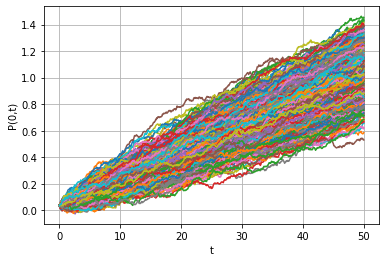

In [127]:
plt.figure(1)
plt.grid()
plt.xlabel("t")
plt.ylabel("P(0,t)")
plt.plot(out["time"],np.transpose(out["R"]))
plt.show()

In [128]:
y_1 = out["R"][0,0] + (mu-sigma**2 /2) * out["time"] 

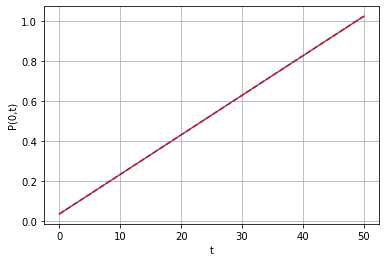

In [129]:
plt.figure(1)
plt.grid()
plt.xlabel("t")
plt.ylabel("P(0,t)")
plt.plot(out["time"],np.mean(np.transpose(out["R"]),axis=1))
plt.plot(out["time"], y_1,"--r")
plt.show()

In [130]:
y_2 = np.sqrt(sigma**2 * out["time"]) 

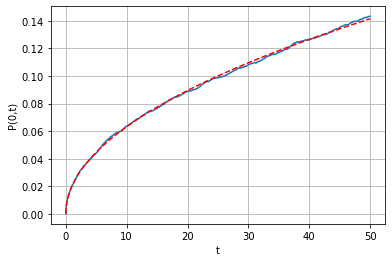

In [131]:
plt.figure(1)
plt.grid()
plt.xlabel("t")
plt.ylabel("P(0,t)")
plt.plot(out["time"],np.std(np.transpose(out["R"]),axis=1))
plt.plot(out["time"], y_2,"--r")
plt.show()

<a id="9"></a> <br>
## Test 1; Comparison between ESG output and assumed term structure 

In this final section, the ESG output is generated and visualy compared to the assumed term structure. The Hull-White model belongs to the family of modells known as HJM. A well known property of this family of models is that the average rate over all simulations should be equal to the input term structure by construction. However in practice, this is often not exactly the case especially in the tails of the curve and if the number of paths is small. The visual check shows the average simulation compared to the input term structure (interpolated/extrapolated by the Smith-Willson algorithm).

***
<span style=color:black>
    <b>Implied and simulated price of a ZCB</b>
</span>
<br>
<span style=color:black>   
    Visual comparison
</span>

Text(0.5, 1.0, 'ZCBs from Hull-White model')

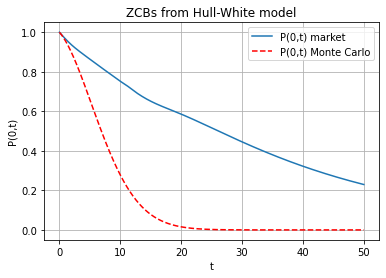

In [132]:
plt.figure(1)
plt.grid()
plt.xlabel("t")
plt.ylabel("P(0,t)")
plt.plot(t, implied_term_structure)
plt.plot(t, P,"--r")
plt.legend(["P(0,t) market", "P(0,t) Monte Carlo"])
plt.title("ZCBs from Hull-White model")

***

In [133]:
test_statistics_bdp_1 = pd.DataFrame(abs(P- implied_term_structure)*10000, columns=["Abs diff in bps"])

***
<span style=color:black>
    <b>Implied and simulated term structure</b>
</span>
<br>
<span style=color:black>   
    Absolute difference in bps
</span>

In [134]:
test_statistics_bdp_1.head()

,Abs diff in bps
0,2.220446e-12
1,6.884390e-01
2,2.758009e+00
3,6.214429e+00
4,1.106268e+01


***

### Test 1; Success criteria

The successful application of the success criteria marks the completion/failiure of the test.

In [135]:
result1 = SuccessTest(test_statistics_bdp_1.values, statistics_mean_max_diff_in_bps, statistics_mean_average_diff_in_bps)

Test failed
Test failed


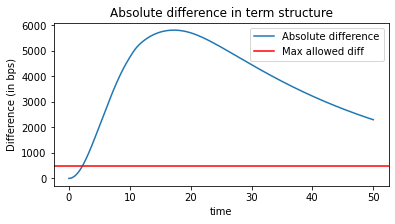

In [136]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(t, test_statistics_bdp_1, label= "Absolute difference")
ax1.axhline(y = statistics_mean_max_diff_in_bps, color = 'r', linestyle = '-',label="Max allowed diff")

ax1.set_xlabel("time")
ax1.set_ylabel("Difference (in bps)")
ax1.set_title('Absolute difference in term structure')
ax1.legend()
fig.set_figwidth(6)
fig.set_figheight(3)

plt.show()

<a id="10"></a> <br>

## Test 2; Comparison between simulated an calculated volatility

The Hull-White model is one of the few widely used short rate models that has a closed-form formula for the calculation of the volatility. The formula is:

$$ V[r(t)｜F_0] = \frac{\sigma^2}{2a}\big( 1-e^{-2at} \big) $$

This fact makes it possible to compare the volatility calculated from the parameters with the simulated volatility. 


In [137]:
paths = Paths(NoOfPaths, NoOfSteps, T, P0t, a, sigma, epsilon)
R = paths["R"]
t = paths["time"]

NameError: name 'Paths' is not defined

In [ ]:
time = np.linspace(start=0,stop=T,num=NoOfSteps+1, endpoint=True)

In [ ]:
var_series = np.var(R, axis=0)

In [ ]:
vol = sigma**2/(2*a)*(1-np.exp(-2*a*time))

In [ ]:
plt.figure(1)
plt.grid()
plt.xlabel("t")
plt.ylabel("V(0,t)")
plt.plot(t,var_series)
plt.plot(t,vol,"--r")
plt.legend(["V(0,t) simulated", "V(0,T) closed formula"])
plt.title("Variance function from Hull-White model")

In [ ]:
test_statistics_bdp_2 = pd.DataFrame(abs(var_series-vol)*10000, columns=["Abs diff in bps"])

***

***
<span style=color:black>
    <b>Theoretical and simulated volatility</b>
</span>
<br>
<span style=color:black>   
    Absolute difference in bps
</span>

In [ ]:
test_statistics_bdp_2.head()

***

### Test 2; Success criteria

The successful application of the success criteria marks the completion/failiure of the test.

In [ ]:
result2 = SuccessTest(test_statistics_bdp_2.values, statistics_vol_max_diff_in_bps, statistics_vol_average_diff_in_bps)

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(t, test_statistics_bdp_2, label= "Absolute difference")
ax1.axhline(y = statistics_vol_max_diff_in_bps, color = 'r', linestyle = '-',label="Max allowed diff")

ax1.set_xlabel("time")
ax1.set_ylabel("Difference (in bps)")
ax1.set_title('Absolute difference in volatility')
ax1.legend()
fig.set_figwidth(6)
fig.set_figheight(3)

plt.show()

<a id="11"></a> <br>
## Conclusion

The tests are successfull if the Hull-White curve generator calibrated using the March 2023 EIOPA curve, passes the success criteria. Based on the preformed tests, if all the tests pass, it is likely that the implementation was generated using a correct methodology and ran using the correct parameters.

In [ ]:
pd.DataFrame(data = [result1, result2], columns = ["Mean test","Max test"],  \
             index= ["Average term structure","Theoretical vs empirical volatility"])